<a href="https://colab.research.google.com/github/11carol/class_area/blob/develop/mascara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Máscara de bit raster**

Instalando a biblioteca rasterio

In [1]:
!pip install rasterio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 20.9 MB 1.5 MB/s 


Importando as bibliotecas

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path

Definindo função que irá chamar as bandas que serão usadas, usando como referência para chamar o "f'*T1{band}.TIF'", abrindo assim as bandas usando a biblioteca rasterio para isso e salvando em image

In [13]:
def load_landsat_image(img_folder, bands):
    image = {}
    path = Path(img_folder)
    for band in bands:
        # considering the landsat images end with *_SR_B#.TIF, we will use it to locate the correct file
        file = next(path.glob(f'*_T1_{band}.TIF'))
        print(f'Opening file {file}')
        ds = rasterio.open(file)
        image.update({band: ds.read(1)})

    return image

Abaixo o img fica responsável por chamar as bandas 3, 4 e 5 mais a imagem QA_PIXEL que é a responsavel por fazer o mascaramento, isto através do caminho posto

In [16]:
# load the image
img = load_landsat_image('/content/img', ['B2', 'B3', 'B4', 'QA_PIXEL'])
img.keys()

Opening file /content/img/LC08_L1TP_228061_20220808_20220818_02_T1_B2.TIF
Opening file /content/img/LC08_L1TP_228061_20220808_20220818_02_T1_B3.TIF
Opening file /content/img/LC08_L1TP_228061_20220808_20220818_02_T1_B4.TIF
Opening file /content/img/LC08_L1TP_228061_20220808_20220818_02_T1_QA_PIXEL.TIF


dict_keys(['B2', 'B3', 'B4', 'QA_PIXEL'])

In [17]:
#printando a QA_PIXEL para mostrar seus valores na matriz
img['QA_PIXEL']

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint16)

Abaixo será criado um dicionário com os valores de seus devidos alvos no caso as nuvens e sombra, que depois será possível contar os pixels e depois mesclar tudo em uma única máscara final, a desvatagem de usar o dicionário é que terá que descrever todos os valores para então prosseguir com o mascaramento

In [40]:
mask_values = {
               'Nuvem dilatada sobre a terra': 21826,
               'Nuvem dilatada sobre a água': 21890,
               'Mid conf Nuvem': 22280,
               'Sombra de nuvem de alta conf': 23888,
               'Água com sombra de nuvem': 23952,
               'Nuvem meio conf com sombra': 24088,
               'Nuvem meio conf com sombra sobre a água': 24216,
               'Nuvem de alta conf com sombra': 24344,
               'Nuvem de alta conf com sombra sobre a água': 24472,
               'Alta conf Cirrus': 54596,
               'Cirrus, nuvem alta': 55052,
               'Cirrus, nuvem meio conf, sombra': 56856,
               'Cirrus, nuvem mid conf, sombra, sobre a água': 56984,
               'Cirrus, nuvem de alta conf, sombra': 57240,
              }


In [19]:
# vamos criar uma matriz de zeros para representar nossa máscara final
final_mask = np.zeros_like(img['QA_PIXEL'])

In [41]:
# Agora percorremos os valores do dicionário
for key, value in mask_values.items():
    # a máscara correspondente será quando QA_PIXEl for igual ao valor da condição
    mask = (img['QA_PIXEL'] == value)
    
    # vamos contar o número de pixels com esta condição (np.count_nonzero faz o trabalho)
    count = np.count_nonzero(mask)
    print(f'{key}: {count}')
    # agora mesclamos a máscara que acabamos de encontrar com nossa máscara final usando o operador ou (|)
    final_mask = final_mask | mask

Nuvem dilatada sobre a terra: 0
Nuvem dilatada sobre a água: 8205
Mid conf Nuvem: 171129
Sombra de nuvem de alta conf: 265997
Água com sombra de nuvem: 0
Nuvem meio conf com sombra: 0
Nuvem meio conf com sombra sobre a água: 0
Nuvem de alta conf com sombra: 0
Nuvem de alta conf com sombra sobre a água: 0
Alta conf Cirrus: 177548
Cirrus, nuvem alta: 19947
Cirrus, nuvem meio conf, sombra: 0
Cirrus, nuvem mid conf, sombra, sobre a água: 0
Cirrus, nuvem de alta conf, sombra: 0


Abaixo será plotado a imagem que dara destaque as nuvens encontradas na imagem

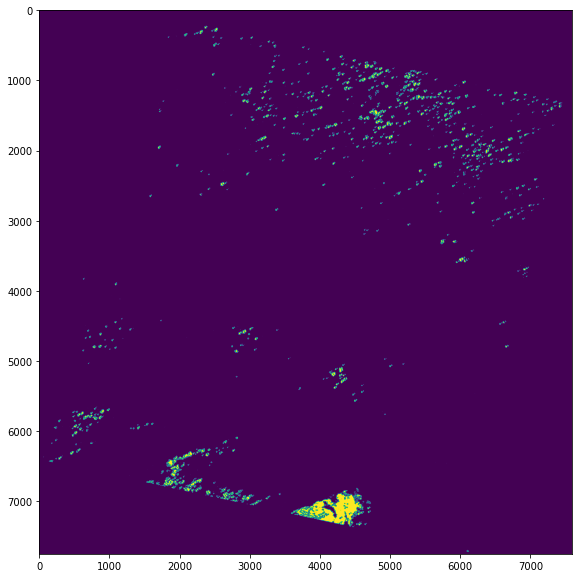

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(final_mask)

Aqui será plotado uma imagem mais ampliada, esta que fica nas proximidades do município de Oriximiná-PA

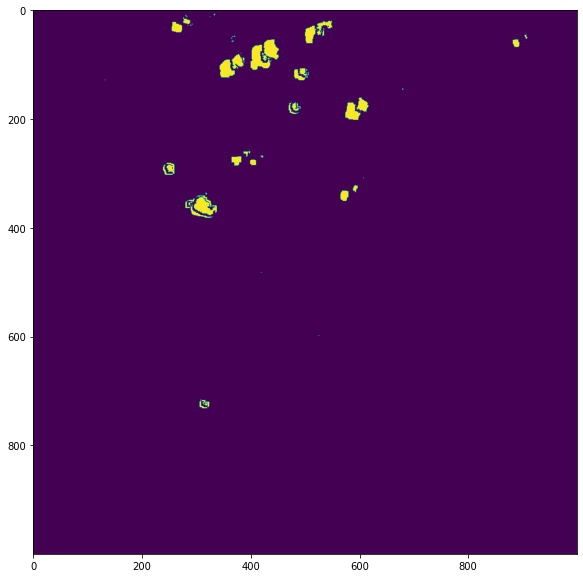

In [27]:
plt.figure(figsize=(10, 10))
plt.imshow(final_mask[4500:5500, 2500:3500])

In [28]:
compare_mask = 0b0000000000011110 
compare_mask 

30

In [30]:
mask_bit = np.bitwise_and(img['QA_PIXEL'], compare_mask)
mask_bit
for value in np.unique(mask_bit):
    print(f'{value:05b}')

00000
00010
00100
00110
01000
01100
10000
10010
10100
10110


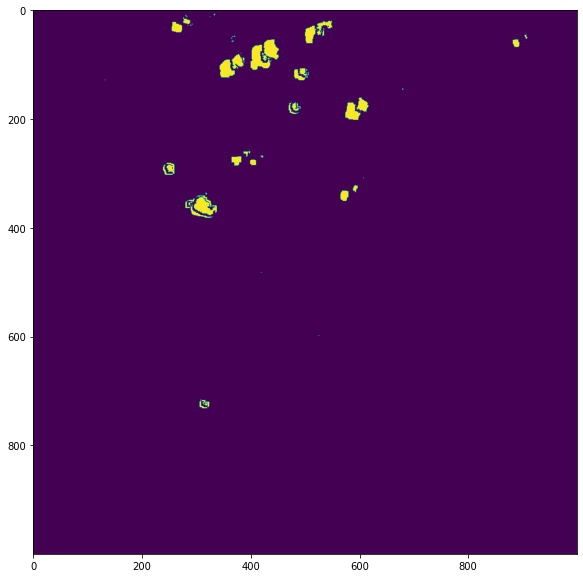

In [31]:
final_mask_bit = mask_bit > 0

plt.figure(figsize=(10, 10))
plt.imshow(final_mask[4500:5500, 2500:3500])

In [32]:
print(f'{23826:016b}')

0101110100010010


In [33]:
L8_flags = {
    'dilated_cloud': 1<<1,
    'cirrus': 1<<2, 
    'cloud': 1<<3,
    'shadow': 1<<4, 
    'snow': 1<<5, 
    'clear': 1<<6,
    'water': 1<<7
}


In [34]:
def get_mask(mask, flags_list):
    
    # first we will create the result mask filled with zeros and the same shape as the mask
    final_mask = np.zeros_like(mask)
    
    # then we will loop through the flags and add the 
    for flag in flags_list:
        # get the mask for this flag
        flag_mask = np.bitwise_and(mask, L8_flags[flag])
        
        # add it to the final flag
        final_mask = final_mask | flag_mask
    
    return final_mask > 0

In [35]:
clouds = get_mask(img['QA_PIXEL'], ['cirrus', 'cloud', 'dilated_cloud'])
shadows = get_mask(img['QA_PIXEL'], ['shadow'])

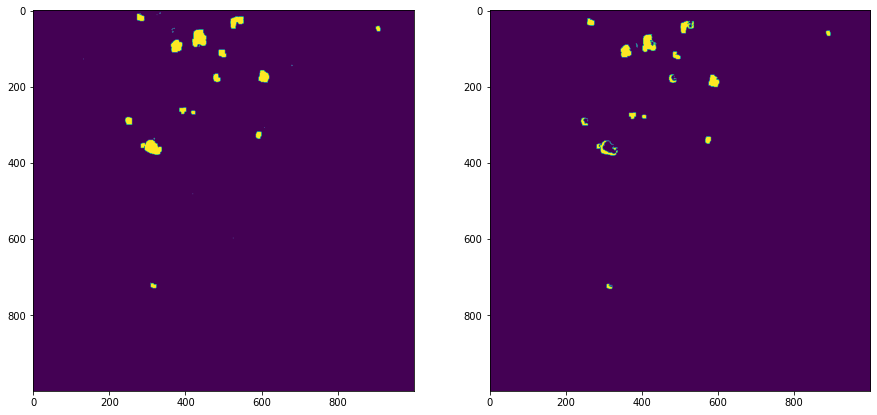

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(clouds[4500:5500, 2500:3500])
ax[1].imshow(shadows[4500:5500, 2500:3500])

In [37]:
def plot_masked_rgb(red, green, blue, mask, color_mask=(1, 0, 0), transparency=0.5, brightness=2):
    
    # to improve our visualization, we will increase the brightness of our values
    red = red / red.max() * brightness
    green = green / green.max() * brightness
    blue = blue / blue.max() * brightness
    
    red = np.where(mask==True, red*transparency+color_mask[0]*(1-transparency), red)
    green = np.where(mask==True, green*transparency+color_mask[1]*(1-transparency), green)
    blue = np.where(mask==True, blue*transparency+color_mask[2]*(1-transparency), blue)
    
    rgb = np.stack([red, green, blue], axis=2)
    
    return rgb

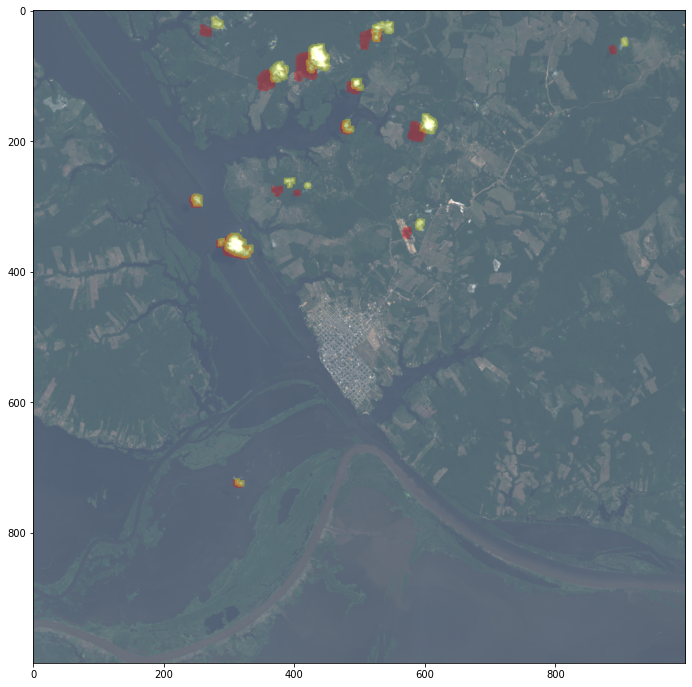

In [38]:
rgb = plot_masked_rgb(img['B4'], img['B3'], img['B2'], shadows, color_mask=(1, 0, 0), transparency=0.7, brightness=2)
rgb = plot_masked_rgb(rgb[..., 0], rgb[..., 1], rgb[..., 2], clouds, color_mask=(1, 1, 0), transparency=0.7, brightness=2)

plt.figure(figsize=(12,12))
plt.imshow(rgb[4500:5500, 2500:3500, 0:3])

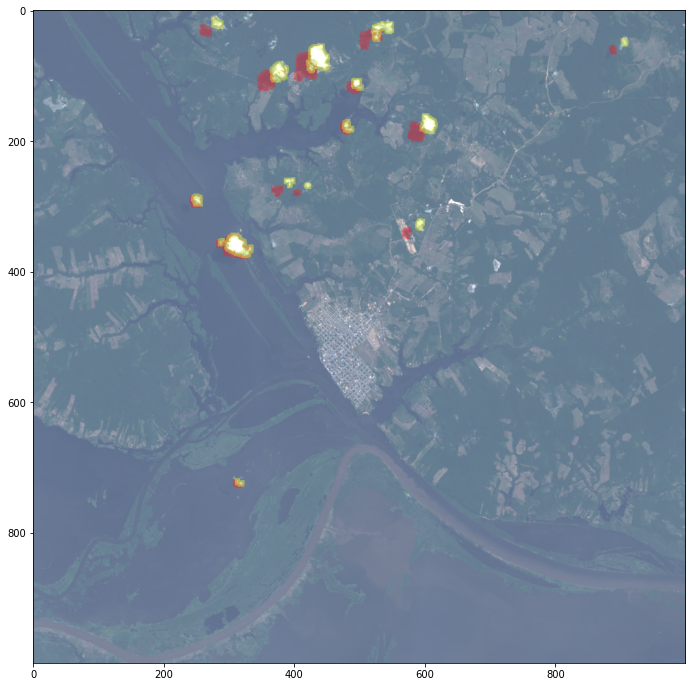

In [39]:
water = get_mask(mask, ['water'])
rgb = plot_masked_rgb(img['B4'], img['B3'], img['B2'], shadows, color_mask=(1, 0, 0), transparency=0.7, brightness=2)
rgb = plot_masked_rgb(rgb[..., 0], rgb[..., 1], rgb[..., 2], clouds, color_mask=(1, 1, 0), transparency=0.7, brightness=2)
rgb = plot_masked_rgb(rgb[..., 0], rgb[..., 1], rgb[..., 2], water, color_mask=(0, 0, 1), transparency=0.7, brightness=2)


plt.figure(figsize=(12,12))
plt.imshow(rgb[4500:5500, 2500:3500, 0:3])